In [ ]:
!pip install geopandas
!pip install geopy
!pip install geocoder
!pip install pygeos

!pip install hdbscan
!pip install contextily
!pip install fuzzywuzzy

In [1]:
import geopy
geopy.geocoders.SERVICE_TO_GEOCODER

{'algolia': geopy.geocoders.algolia.AlgoliaPlaces,
 'arcgis': geopy.geocoders.arcgis.ArcGIS,
 'azure': geopy.geocoders.azure.AzureMaps,
 'baidu': geopy.geocoders.baidu.Baidu,
 'baiduv3': geopy.geocoders.baidu.BaiduV3,
 'banfrance': geopy.geocoders.banfrance.BANFrance,
 'bing': geopy.geocoders.bing.Bing,
 'databc': geopy.geocoders.databc.DataBC,
 'geocodeearth': geopy.geocoders.geocodeearth.GeocodeEarth,
 'geocodefarm': geopy.geocoders.geocodefarm.GeocodeFarm,
 'geonames': geopy.geocoders.geonames.GeoNames,
 'google': geopy.geocoders.googlev3.GoogleV3,
 'googlev3': geopy.geocoders.googlev3.GoogleV3,
 'geolake': geopy.geocoders.geolake.Geolake,
 'here': geopy.geocoders.here.Here,
 'ignfrance': geopy.geocoders.ignfrance.IGNFrance,
 'mapbox': geopy.geocoders.mapbox.MapBox,
 'mapquest': geopy.geocoders.mapquest.MapQuest,
 'maptiler': geopy.geocoders.maptiler.MapTiler,
 'nominatim': geopy.geocoders.nominatim.Nominatim,
 'opencage': geopy.geocoders.opencage.OpenCage,
 'openmapquest': geopy.ge

In [12]:
!ls entities/1913

1913.zip			  innsbrucker_nachrichten.json
abo_underrattelser.json		  le_matin.json
arbeiter_zeitung.json		  neue_freie_presse.json
helsingin_sanomat.json		  uusi_aura.json
hufvudstadsbladet.json		  uusi_suometar.json
illustrierte_kronen_zeitung.json  vastra_finland.json


In [13]:
import geopandas as gpd

geometry = gpd.GeoDataFrame(columns=['mention', 'geometry', 'address'])

geometry

,mention,geometry,address


In [33]:
unique_locs = locs.mention.value_counts()

unique_locs

Wien                             4989
Deutschland                      3113
London                           2848
Berlin                           2075
Oesterreich                      2011
                                 ... 
Olai                                1
Ostlibyen                           1
Apollogasse 1 , im Hofe links       1
Hohenzollern = Schanzwerk           1
Argesulfluß                         1
Name: mention, Length: 33160, dtype: int64

In [34]:
unique_locs[unique_locs > 1]

Wien                   4989
Deutschland            3113
London                 2848
Berlin                 2075
Oesterreich            2011
                       ... 
Hauptstrasse 78           2
Grooningen                2
Fadoriten                 2
I . Zelinkagasse 14       2
Komp                      2
Name: mention, Length: 7294, dtype: int64

<AxesSubplot:>

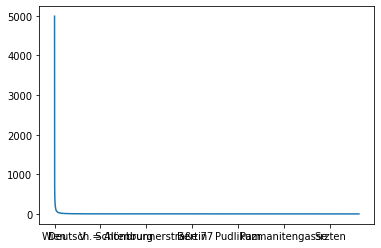

In [35]:
unique_locs.plot()

In [34]:
!ls entities/1920

arbeiter_zeitung.json		  le_matin.json		  new_york_herald.json
illustrierte_kronen_zeitung.json  l_oeuvre.json
innsbrucker_nachrichten.json	  neue_freie_presse.json


In [ ]:
from geopandas.tools import geocode
import geopandas as gpd
import pandas as pd
import time

from os.path import isfile

paper = 'illustrierte_kronen_zeitung'

for year in ['1913', '1914', '1915', '1916', '1917', '1918', '1919', '1920']:
    geometry = gpd.GeoDataFrame(columns=['mention', 'geometry', 'address'])
    outpath = f'locations/{year}/{paper}.geojson'
    if isfile(outpath):
        print('Loading geometry', outpath)
        geometry = gpd.read_file(outpath)
            
    print('reading', f'entities/{year}/{paper}.json')
    locs = gpd.GeoDataFrame(pd.read_json(f'entities/{year}/{paper}.json'))
    unique_locs = locs.mention.value_counts()
    print(unique_locs[unique_locs > 1].shape[0])

    start = time.time()

    for i, item in enumerate(unique_locs[unique_locs > 1].iteritems()):
        if (i+1) % 1000 == 0:
            print(f"{i+1}/{unique_locs[unique_locs > 1].shape[0]} ({((i+1) / unique_locs[unique_locs > 1].shape[0]):.3f}) - {(time.time() - start):.3f}")
            start = time.time()

        place_name, freq = item

        if place_name in geometry.mention.tolist(): continue

        try:
            out = geocode(place_name, provider='nominatim', user_agent='autogis_xx', timeout=4)
            out['mention'] = place_name
            out['freq'] = freq
        except Exception as error:
            print(error)
            geometry.to_file(f'locations/{year}/{paper}.geojson', driver='GeoJSON') # shape per default
            time.sleep(5)

        geometry = geometry.append(out)

    print(f'Saving {year}/{paper}.geojson')
    geometry.to_file(f'locations/{year}/{paper}.geojson', driver='GeoJSON') # shape per default

reading entities/1913/illustrierte_kronen_zeitung.json
10037
1000/10037 (0.100) - 608.503
HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Landstra%C3%9Fe+Hauptstra%C3%9Fe&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=4)",))
2000/10037 (0.199) - 573.286
HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Landstra%C3%9Fe+Hauptstrasse+88&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=4)",))
3000/10037 (0.299) - 559.215
HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Bezirk+%2C+Hauptstra%C3%9Fe+27&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed

In [7]:
import geopandas as gpd
# gpd.options.use_pygeos = False

shape_1914 = gpd.read_file('shapefiles/cntry1914.shp')
shape_1914.set_index('NAME', inplace=True)

In [3]:
import geopandas as gpd

geometry

,mention,address,freq,geometry
0,Wien,"Wien, Österreich",5240.0,POINT (16.37250 48.20835)
1,Deutschland,Deutschland,2440.0,POINT (10.42345 51.08342)
2,Rußland,Россия,2388.0,POINT (97.74531 64.68631)
3,Berlin,"Berlin, 10117, Deutschland",2323.0,POINT (13.38886 52.51704)
4,Oesterreich,Österreich,2201.0,POINT (13.20000 47.20000)
...,...,...,...,...
6270,Slobodzia,"Слобода, Новоселицька міська громада, Чернівец...",2.0,POINT (26.19518 48.27804)
6271,beschossen,None,2.0,None
6272,Kriegsanleihen,None,2.0,None
6273,Liochten - steinstrasse,None,2.0,None


In [6]:
shape_1914.index

Index(['Luxembourg', 'Switzerland', 'Cyprus', 'Bhutan', 'Qatar',
       'United Arab Emirates', 'Cuba', 'United States', 'Haiti',
       'Dominican Republic',
       ...
       'Rhodesia', 'Japan', 'France', 'German Empire', 'Arabia (Nejd)',
       'Arabia (Nejd)', 'Arabia (Nejd)', 'Mongolia', 'Russia', 'Sakhalan'],
      dtype='object', name='NAME', length=125)

### What did the Geocoder miss?

In [28]:
geometry[geometry.address.isna()].to_csv(f'{paper}{year}_failed.csv')

In [11]:
geometry[geometry.address.isna()]

,mention,geometry,address,freq
0,Spielplan,GEOMETRYCOLLECTION EMPTY,None,2097.0
0,Klubcafé,GEOMETRYCOLLECTION EMPTY,None,405.0
0,Salonich,GEOMETRYCOLLECTION EMPTY,None,343.0
0,Deutsches Volkstheater,GEOMETRYCOLLECTION EMPTY,None,317.0
0,X . Laxenburgerstraße 8,GEOMETRYCOLLECTION EMPTY,None,315.0
...,...,...,...,...
0,Halbgasse Nr,GEOMETRYCOLLECTION EMPTY,None,2.0
0,WienLt . Bf .,GEOMETRYCOLLECTION EMPTY,None,2.0
0,"X . Weihburggasse 9 ,",GEOMETRYCOLLECTION EMPTY,None,2.0
0,Itzkany,GEOMETRYCOLLECTION EMPTY,None,2.0


In [31]:
from fuzzywuzzy import fuzz, process
from scipy.spatial.distance import pdist

query = 'WienLt . Bf .'

for mention in locs[geometry.geometry.isna()].mention.unique():
    ratio = fuzz.ratio(query, mention)
    if ratio > 60: print(mention, '-', ratio)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  
